In [6]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile # Import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import gradio as gr
from google.colab import files

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [7]:

# 2. Load dataset (upload Emotion_final.csv from Kaggle)

print("Please upload Emotion_final.csv (Kaggle emotions dataset)...")
uploaded = files.upload()  # select Emotion_final.csv

csv_name = list(uploaded.keys())[0]

# Check if the uploaded file is a zip file
if csv_name.endswith('.zip'):
    with zipfile.ZipFile(io.BytesIO(uploaded[csv_name]), 'r') as z:
        z.extractall('.') # Extract to current directory
    # Assuming Emotion_final.csv is directly inside the zip
    csv_filename = 'Emotion_final.csv'
    df = pd.read_csv(csv_filename)
else:
    df = pd.read_csv(io.BytesIO(uploaded[csv_name]))

print("\nRaw columns:", df.columns.tolist())
print("\nSample rows:")
print(df.head())

# Normalize column names (in case they are slightly different)
df = df.rename(columns={df.columns[0]: "Text", df.columns[1]: "Emotion"})

Please upload Emotion_final.csv (Kaggle emotions dataset)...


Saving Emotion_final.csv to Emotion_final (4).csv

Raw columns: ['Text', 'Emotion']

Sample rows:
                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger



Class distribution:
Emotion
happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: count, dtype: int64


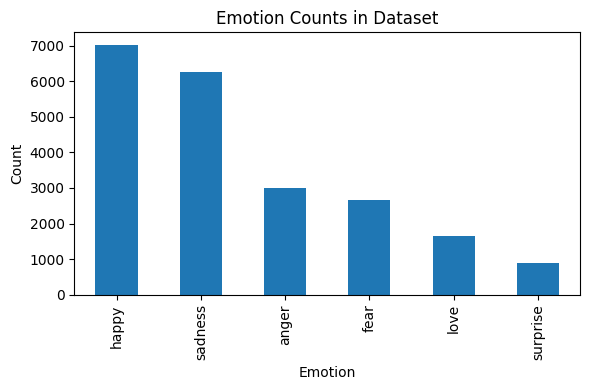

In [8]:

# 3. Simple EDA

print("\nClass distribution:")
print(df["Emotion"].value_counts())

plt.figure(figsize=(6,4))
df["Emotion"].value_counts().plot(kind="bar")
plt.title("Emotion Counts in Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [9]:
# 4. Preprocessing

texts = df["Text"].astype(str).values
labels = df["Emotion"].values

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

num_classes = len(label_encoder.classes_)
print("\nEmotion classes:", label_encoder.classes_)
print("Number of classes:", num_classes)

# Tokenization
max_words = 10000   # vocabulary size
max_len = 50        # max tokens per sentence

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

X_train, X_test, y_train, y_test = train_test_split(
    padded, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Emotion classes: ['anger' 'fear' 'happy' 'love' 'sadness' 'surprise']
Number of classes: 6

Train shape: (17167, 50) Test shape: (4292, 50)


In [10]:
# 5. Build BiLSTM model

embedding_dim = 64

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Explicitly build the model before summary
model.build(input_shape=(None, max_len))

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print("\nModel summary:")
model.summary()


Model summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714,694 (2.73 MB)

 Trainable params: 714,694 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3252 - loss: 1.6213 - val_accuracy: 0.6194 - val_loss: 1.0422
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6815 - loss: 0.8627 - val_accuracy: 0.7798 - val_loss: 0.6259
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8556 - loss: 0.4253 - val_accuracy: 0.8430 - val_loss: 0.4765
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9279 - loss: 0.2223 - val_accuracy: 0.8608 - val_loss: 0.4919
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9505 - loss: 0.1578 - val_accuracy: 0.8626 - val_loss: 0.4804
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9589 - loss: 0.1275 - val_accuracy: 0.8561 - val_loss: 0.5204


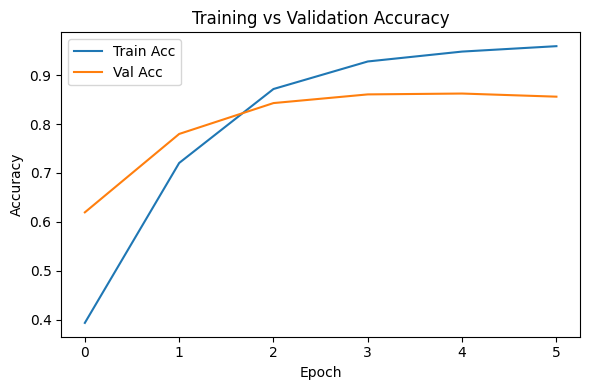

In [11]:

# 6. Train the model

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Training vs validation accuracy plot
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


Test Accuracy: 0.8511
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.73      0.81      0.77       599
        fear       0.84      0.77      0.80       530
       happy       0.91      0.90      0.91      1406
        love       0.74      0.77      0.75       328
     sadness       0.89      0.93      0.91      1253
    surprise       0.79      0.41      0.54       176

    accuracy                           0.85      4292
   macro avg       0.82      0.77      0.78      4292
weighted avg       0.85      0.85      0.85      4292



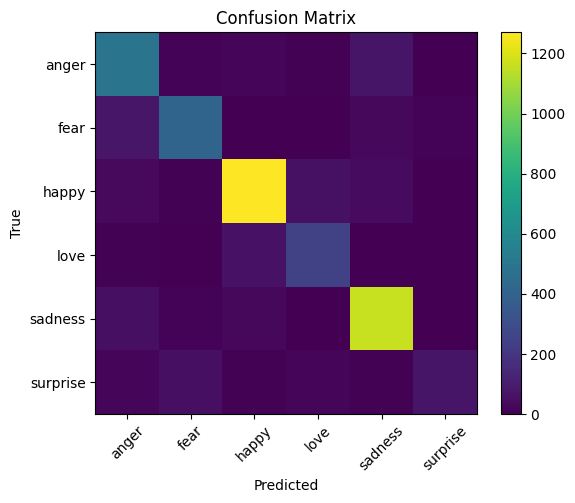

In [12]:


# 7. Evaluate on test data

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [13]:

# 8. Save model & encoders (optional)

import pickle

model.save("emotion_model.h5")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("\nSaved model as emotion_model.h5, tokenizer.pkl, label_encoder.pkl")


Saved model as emotion_model.h5, tokenizer.pkl, label_encoder.pkl


In [14]:
# 9. Mood logging system (daily data entry)


EMOJI_MAP = {
    "anger": "😡",
    "disgust": "🤢",
    "fear": "😨",
    "happy": "😄",
    "joy": "😄",
    "love": "❤️",
    "sadness": "😢",
    "sad": "😢",
    "surprise": "😲",
    "neutral": "😐"
}

LOG_FILE = "mood_log.csv"

def log_mood(text, emotion):
    """Append a new mood entry into CSV with timestamp, text and emotion."""
    ts = pd.Timestamp.now()
    row = pd.DataFrame([{
        "timestamp": ts,
        "text": text,
        "emotion": emotion
    }])
    file_exists = os.path.exists(LOG_FILE)
    row.to_csv(LOG_FILE, mode="a", header=not file_exists, index=False)

def analyze_and_log(text):
    """Predict emotion, log it, and return prediction + emoji."""
    if not text.strip():
        return "Please type something.", ""

    # Preprocess & predict
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")
    probs = model.predict(pad)[0]
    idx = int(np.argmax(probs))
    emotion = label_encoder.classes_[idx]
    emoji = EMOJI_MAP.get(emotion.lower(), "🙂")
    confidence = float(np.max(probs)) * 100.0
    result_text = f"Emotion: {emotion} (confidence: {confidence:.2f}%)"

    # Log to CSV
    log_mood(text, emotion)

    return result_text, emoji

def mood_stats():
    """
    Read mood_log.csv and return:
    - Summary text
    - Bar plot of emotion distribution
    - Line plot of number of logs per day
    """
    if not os.path.exists(LOG_FILE):
        return "No mood data logged yet. Please log some moods first.", None, None

    df_log = pd.read_csv(LOG_FILE, parse_dates=["timestamp"])
    if df_log.empty:
        return "Mood log is empty. Please add some entries.", None, None

    # Overall emotion distribution
    fig1 = plt.figure(figsize=(6,4))
    df_log["emotion"].value_counts().plot(kind="bar")
    plt.title("Overall Emotion Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.tight_layout()

    # Daily log count
    df_log["date"] = df_log["timestamp"].dt.date
    daily_counts = df_log.groupby("date").size()

    fig2 = plt.figure(figsize=(6,4))
    daily_counts.plot(marker="o")
    plt.title("Daily Mood Log Count")
    plt.xlabel("Date")
    plt.ylabel("Number of Entries")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Summary text
    total_logs = len(df_log)
    days_tracked = df_log["date"].nunique()
    most_common_emotion = df_log["emotion"].value_counts().idxmax()

    summary = (
        f"Total mood entries: {total_logs}\n"
        f"Days tracked: {days_tracked}\n"
        f"Most common emotion: {most_common_emotion}"
    )

    return summary, fig1, fig2

In [15]:

# 10. Gradio App with two tabs:
#     (1) Log today's mood
#     (2) View mood analytics (graphs)


with gr.Blocks() as demo:
    gr.Markdown("# EMO TRACK: Deep Learning Emotion & Mood Analytics")
    gr.Markdown(
        "Enter your daily thoughts, the model predicts your emotion, "
        "logs it, and shows mood statistics over time."
    )

    with gr.Tab("Log Today's Mood"):
        input_box = gr.Textbox(
            lines=3,
            placeholder="Type how you feel today... (e.g., I am excited about my project!)",
            label="Your Message"
        )
        predict_btn = gr.Button("Analyze & Save Mood")
        pred_output = gr.Textbox(label="Prediction")
        emoji_output = gr.Textbox(label="Emoji")

        predict_btn.click(
            fn=analyze_and_log,
            inputs=input_box,
            outputs=[pred_output, emoji_output]
        )

    with gr.Tab("View Mood Analytics"):
        stats_btn = gr.Button("Refresh Mood Stats")
        stats_text = gr.Textbox(label="Summary")
        plot1 = gr.Plot(label="Emotion Distribution")
        plot2 = gr.Plot(label="Daily Mood Logs")

        stats_btn.click(
            fn=mood_stats,
            inputs=None,
            outputs=[stats_text, plot1, plot2]
        )

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a6136a25a081c06948.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
